<a href="https://colab.research.google.com/github/hiiiiiiiiiieve/Anomaly-Detection/blob/main/LSTM-AE%2C_timesteps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 의견
* 그림 2는 그림 1에 나타낸 복원 오차 그래프에서 분할 비율 가 0.5, 0.25일 때 분할된 범위를 나타낸 것이다. 이 예는 분할 비율이 0.5일 때 보다 0.25일 때 이상 데이터를 더 많이 감지하지만, 상대적으로 더 많은 정상 데이터를 이상 데이터로 결정한다. 이 경우에 거짓 음성은 감소하지만, 거짓 양성은 증가한다. 즉, 분할 비율이 LSTM AE의 이상 감지 성능에 영향을 줄 수 있다.(LSTM 오토인코더를 이용한 이상 탐지의 임계치 결정 방법)
* 공장에서 이상치를 민감하게 판단하여 최대한 고장을 줄이기 위해서는 이상 데이터를 정상 데이터로 잘못 인식하는 것보다는 '상대적으로 더 많은 정상 데이터를 이상 데이터로 결정'하는 것이 더 낫다고 판단하여 0.5로 임계치 결정

# 데이터 확인

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd

df1 = pd.read_csv("/content/drive/MyDrive/study/Private/1. 시계열 데이터 예측/1. dataset/gt_2011.csv")
df2 = pd.read_csv("/content/drive/MyDrive/study/Private/1. 시계열 데이터 예측/1. dataset/gt_2012.csv")
df3 = pd.read_csv("/content/drive/MyDrive/study/Private/1. 시계열 데이터 예측/1. dataset/gt_2013.csv")
df4 = pd.read_csv("/content/drive/MyDrive/study/Private/1. 시계열 데이터 예측/1. dataset/gt_2014.csv")
df5 = pd.read_csv("/content/drive/MyDrive/study/Private/1. 시계열 데이터 예측/1. dataset/gt_2015.csv")
gt_at = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
gt_at = gt_at[['AT']]

# LSTM-Autoencoder timesteps
## 10

Epoch 1/50
1148/1148 [==============================] - 46s 37ms/step - loss: 0.0296
Epoch 2/50
1148/1148 [==============================] - 39s 34ms/step - loss: 0.0032
Epoch 3/50
1148/1148 [==============================] - 39s 34ms/step - loss: 0.0024
Epoch 4/50
1148/1148 [==============================] - 39s 34ms/step - loss: 0.0016
Epoch 5/50
1148/1148 [==============================] - 40s 35ms/step - loss: 0.0018
Epoch 6/50
1148/1148 [==============================] - 40s 34ms/step - loss: 0.0015
Epoch 7/50
1148/1148 [==============================] - 44s 38ms/step - loss: 0.0014
Epoch 8/50
1148/1148 [==============================] - 38s 33ms/step - loss: 0.0013
Epoch 9/50
1148/1148 [==============================] - 41s 36ms/step - loss: 0.0010
Epoch 10/50
1148/1148 [==============================] - 43s 37ms/step - loss: 8.6580e-04
Epoch 11/50
1148/1148 [==============================] - 39s 34ms/step - loss: 8.0147e-04
Epoch 12/50
1148/1148 [==============================] 

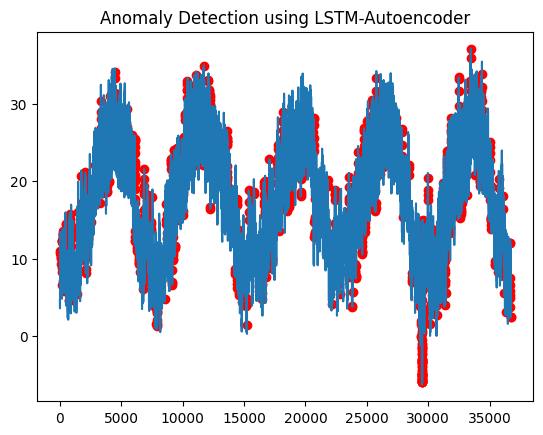

Number of anomalies: 1837


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from sklearn.cluster import KMeans
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed

# LSTM-Autoencoder 모델 정의
scaler = StandardScaler()
gt_at['AT_scaled'] = scaler.fit_transform(gt_at[['AT']])
timesteps = 10  # 시퀀스 길이
input_dim = 1   # 특성 수 (AT만 사용)

def create_lstm_autoencoder(timesteps, input_dim):
    inputs = Input(shape=(timesteps, input_dim))
    """128: LSTM 레이어 유닛 -> 클수록 정보 학습과 저장 많이 할 수 있지만 과적합도 증가하는 문제 발생 가능"""
    """relu: 비선형성, 계산 효율성, 기울기 소실 문제 완화, 희소 활성화 가능
    BUT 죽은 relu(음수 입력에 대해 0이 출력되어 업데이트 안되는 문제 발생)
    activation=LeakyReLU(alpha=0.01) 활용해보기"""
    # 인코더
    encoded = LSTM(128, activation='relu', return_sequences=False)(inputs)
    encoded = RepeatVector(timesteps)(encoded)
    # 디코더
    decoded = LSTM(128, activation='relu', return_sequences=True)(encoded)
    decoded = TimeDistributed(Dense(input_dim))(decoded)
    autoencoder = Model(inputs, decoded)
    return autoencoder

autoencoder = create_lstm_autoencoder(timesteps, input_dim)
autoencoder.compile(optimizer='adam', loss='mse')

# 시퀀스 데이터 생성
def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps):
        seq = data[i:i + timesteps]
        sequences.append(seq)
    return np.array(sequences)

sequences = create_sequences(gt_at['AT_scaled'].values.reshape(-1, 1), timesteps)
autoencoder.fit(sequences, sequences, epochs=50, batch_size=32, shuffle=True)

# 재구성 오차 계산
reconstructed_sequences = autoencoder.predict(sequences)
mse = np.mean(np.power(sequences - reconstructed_sequences, 2), axis=1)

# 이상 탐지 결과 시각화
## 임계값은 보통 아래와 같이 결정됨
threshold = np.percentile(mse, 95)  # 95% 퍼센타일을 이상 탐지 임계값으로 설정
anomalies = mse > threshold

plt.plot(gt_at['AT'].values)
plt.scatter(np.where(anomalies)[0], gt_at['AT'].values[np.where(anomalies)[0]], color='r')  # 수정된 부분
plt.title('Anomaly Detection using LSTM-Autoencoder')
plt.show()

# 이상치 개수 계산 및 출력
num_anomalies = np.sum(anomalies)
print(f"Number of anomalies: {num_anomalies}")

## 30

In [ ]:
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from sklearn.cluster import KMeans

# LSTM-Autoencoder 모델 정의
scaler = StandardScaler()
gt_at['AT_scaled'] = scaler.fit_transform(gt_at[['AT']])
timesteps = 30  # 시퀀스 길이
input_dim = 1   # 특성 수 (AT만 사용)

def create_lstm_autoencoder(timesteps, input_dim):
    inputs = Input(shape=(timesteps, input_dim))
    # 인코더
    encoded = LSTM(128, activation='relu', return_sequences=False)(inputs)
    encoded = RepeatVector(timesteps)(encoded)
    # 디코더
    decoded = LSTM(128, activation='relu', return_sequences=True)(encoded)
    decoded = TimeDistributed(Dense(input_dim))(decoded)
    autoencoder = Model(inputs, decoded)
    return autoencoder

autoencoder = create_lstm_autoencoder(timesteps, input_dim)
autoencoder.compile(optimizer='adam', loss='mse')

# 시퀀스 데이터 생성
def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps):
        seq = data[i:i + timesteps]
        sequences.append(seq)
    return np.array(sequences)

sequences = create_sequences(gt_at['AT_scaled'].values.reshape(-1, 1), timesteps)
autoencoder.fit(sequences, sequences, epochs=50, batch_size=32, shuffle=True)

# 재구성 오차 계산
reconstructed_sequences = autoencoder.predict(sequences)
mse = np.mean(np.power(sequences - reconstructed_sequences, 2), axis=1)

# 이상 탐지 결과 시각화
## 임계값은 보통 아래와 같이 결정됨
threshold = np.percentile(mse, 95)  # 95% 퍼센타일을 이상 탐지 임계값으로 설정
anomalies = mse > threshold

plt.plot(gt_at['AT'].values)
plt.scatter(np.where(anomalies)[0], gt_at['AT'].values[np.where(anomalies)[0]], color='r')  # 수정된 부분
plt.title('Anomaly Detection using LSTM-Autoencoder')
plt.show()

# 이상치 개수 계산 및 출력
num_anomalies = np.sum(anomalies)
print(f"Number of anomalies: {num_anomalies}")

Epoch 1/50
1147/1147 [==============================] - 108s 92ms/step - loss: 0.0662
Epoch 2/50
1147/1147 [==============================] - 112s 97ms/step - loss: 0.0098
Epoch 3/50
1147/1147 [==============================] - 104s 90ms/step - loss: 0.0076
Epoch 4/50
1147/1147 [==============================] - 104s 90ms/step - loss: 0.0063
Epoch 5/50
1147/1147 [==============================] - 103s 90ms/step - loss: 0.0057
Epoch 6/50
1147/1147 [==============================] - 103s 90ms/step - loss: 0.0050
Epoch 7/50
1147/1147 [==============================] - 109s 95ms/step - loss: 0.0048
Epoch 8/50
1147/1147 [==============================] - 108s 94ms/step - loss: 0.0044
Epoch 9/50
1147/1147 [==============================] - 106s 92ms/step - loss: 0.0037
Epoch 10/50
1147/1147 [==============================] - 104s 91ms/step - loss: 0.0035
Epoch 11/50
1147/1147 [==============================] - 104s 90ms/step - loss: 0.0032
Epoch 12/50
1147/1147 [=============================